In [12]:
#Imports
import urllib
import urllib.request
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import ssl
import gzip
import json

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
!pip install xgboost
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# PREPROCESSING. More recent, 2018 dataset https://nijianmo.github.io/amazon/index.html
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

context = ssl._create_unverified_context()

data = urllib.request.urlopen(\
       'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Automotive_5.json.gz', context=context)

df = getDF(data)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1.0,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN
2,1.0,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,NaN,NaN
3,3.0,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,NaN,NaN
4,5.0,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN


In [14]:
#Drop rows missing either the rating or the review text
df.dropna(inplace = True, subset=['overall', 'reviewText', 'summary'])

#Save complete database, too large to run in production
full_df = df

#Set seed so data will be equal in all executions
np.random.seed(10)

#This size ensures enough data is present for results, without introducing large runtimes
new_size = 200000 #df.shape[0] for full dataset

#Drop random indices until dataframe has new_size amount of rows
df = df.drop(np.random.choice(df.index, df.shape[0] - new_size, replace=False))

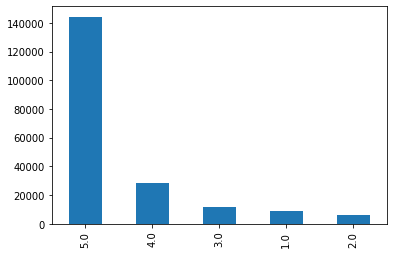

In [15]:
#Distribution of values in the dataset
df['overall'].value_counts().plot(kind='bar')

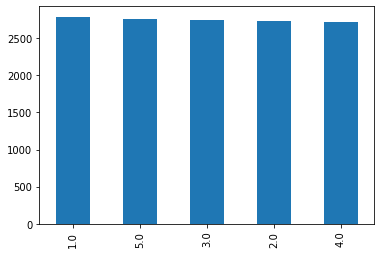

In [16]:
#Amount of datapoints within each category (must be smaller or equal to datapoints in smallest category)
# new_size = df['overall'].value_counts().min() #df['overall'].value_counts().min()
# new_size = 40000
new_size = df['overall'].value_counts().min()
size_adjusted_df = pd.DataFrame(columns=df.columns)

for value in df['overall'].unique():
  #Separate each category
  value_df = df[df['overall'] == value]
  #Remove random samples until equal to new_size
  size_adjusted_df = pd.concat([size_adjusted_df, value_df.drop(np.random.choice(value_df.index,value_df.shape[0] - new_size, replace=False))], ignore_index=True)

#Set adjusted dataframe as default
one_third = size_adjusted_df.sample(frac = 0.33)
size_adjusted_df = size_adjusted_df.drop(one_third.index)

two_third = size_adjusted_df.sample(frac = 0.33)
size_adjusted_df = size_adjusted_df.drop(two_third.index)

# Creating dataframe with
# rest of the 50% values
df = size_adjusted_df

#Visualize new distribution
df['overall'].value_counts().plot(kind='bar')

In [17]:
#Size of reviews can influence scoring
def makeWords(df):
  from nltk.corpus import stopwords
  nltk.download('stopwords')
  stopwords = set(stopwords.words('english'))
  import re
  def tokenize_content(content):
    return list(filter(lambda x: (re.match(r"^^[a-zA-Z]+$", x) and (x not in stopwords)), map(str.lower,nltk.word_tokenize(content))))

  words_df = df[['reviewText']]
  words_df['reviewText_parsed'] = words_df.reviewText.apply(tokenize_content)

  words_df['amount'] = words_df.reviewText_parsed.apply(lambda x: len(x))
  words_df['overall'] = df['overall']

  return words_df

words_df = makeWords(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#Contrast words present may vary with stars
def getMoreWordyStuff(words_df):
  contrast_words = ['also', '[as', 'well', 'as]', 'both', 'comparatively', '[in', 'the', 'same', 'way]', '[in', 'addition]', '[just', 'as]', 'like', '[most', 'important]', 'similarly', '[the', 'same', 'as]', 'too', 'although', 'besides', 'but', '[compared', 'with]', 'conversely', 'differ', '[even', 'though]', 'furthermore', 'however', '[in', 'contrast', 'to]', 'instead', '[less', 'than]', '[more', 'than]', 'nevertheless', 'notwithstanding', '[on', 'the', 'other', 'hand]', 'otherwise', '[rather', 'than]', 'regardless', 'though', 'unless', 'unlike', 'while', 'yet']

  words_df['contrast'] = words_df.reviewText_parsed.apply(lambda x: sum([x.count(word) for word in contrast_words])/(len(x)+1))
  return words_df

words_df = getMoreWordyStuff(words_df)

In [19]:
# future_tense = ["VBD", "VBN"]
# past_tense = ["MD"]

# def tense(sentence):
#   word_classification = pos_tag(sentence)
#   future_verbs = len([word for word in word_classification if word[1] in future_tense])
#   past_verbs = len([word for word in word_classification if word[1] in past_tense])
#   return future_verbs - past_verbs

# words_df['tense'] = words_df.reviewText.apply(lambda x: x.split(' ')).apply(tense)

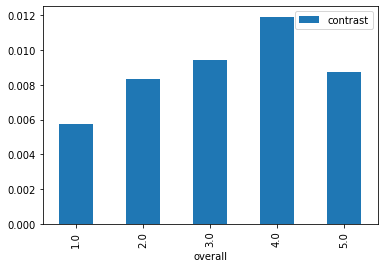

<Figure size 432x288 with 0 Axes>

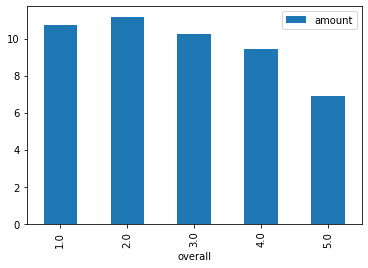

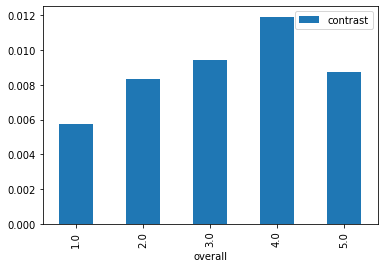

In [20]:
plt.figure(0)
(words_df[['overall', 'amount']].groupby(by='overall').sum() / new_size).plot(kind='bar')
plt.figure(1)
(words_df[['overall', 'contrast']].groupby(by='overall').sum() / new_size).plot(kind='bar')
plt.figure(2)
# (words_df[['overall', 'tense']].groupby(by='overall').sum() / new_size).plot(kind='bar')

In [21]:
def intensity(df):   
  #Sentiment needs only the review text
  sentiment_df = df[['reviewText', 'summary']]

  #Initialize analyzer
  sia = SentimentIntensityAnalyzer()

  #Calculate compound polarity
  sentiment_df['sentiment_raw'] = sentiment_df.reviewText.apply(lambda x: sia.polarity_scores(x)['compound'])
  sentiment_df['sentiment_summary_raw'] = sentiment_df.summary.apply(lambda x: sia.polarity_scores(x)['compound'])

  #Scale and round to a 1-5 score (where -1 is 1 and 1 is 5)
  sentiment_df['sentiment'] = np.ceil(((1+sentiment_df.sentiment_raw)/2) * 5)
  sentiment_df['sentiment_summary'] = np.ceil(((1+sentiment_df.sentiment_summary_raw)/2) * 5)

  return sentiment_df

In [22]:
def text_blob(df):
    text_blob_df = df[['reviewText', 'summary']]

    text_blob_df['reviewText'] = text_blob_df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split())).replace('[^ws]','')
    text_blob_df['summary'] = text_blob_df['summary'].apply(lambda x: " ".join(x.lower() for x in x.split())).replace('[^ws]','')

    st = PorterStemmer()
    text_blob_df['reviewText'] = text_blob_df['reviewText'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    text_blob_df['summary'] = text_blob_df['summary'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    text_blob_df['sentiment_raw'] = text_blob_df['reviewText'].apply(lambda x: pd.to_numeric(TextBlob(x).sentiment)[0])
    text_blob_df['sentiment_summary_raw'] = text_blob_df['summary'].apply(lambda x: pd.to_numeric(TextBlob(x).sentiment)[0])

    text_blob_df['sentiment'] = text_blob_df['sentiment_raw'].apply(lambda x: np.round(x * 2.00 + 4.0))
    text_blob_df['sentiment_summary'] = text_blob_df['sentiment_summary_raw'].apply(lambda x: np.round(x * 2.00 + 4.0))

    return text_blob_df

In [23]:
def vader(df):   
    #VADER
    !pip install vaderSentiment
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    vader_df = df[['reviewText', 'summary']]

    vader_sentiment = SentimentIntensityAnalyzer()

    vader_df['sentiment_raw'] = vader_df['reviewText'].apply(lambda x: vader_sentiment.polarity_scores(x).get("compound"))
    vader_df['sentiment_summary_raw'] = vader_df['summary'].apply(lambda x: vader_sentiment.polarity_scores(x).get("compound"))

    vader_df['sentiment'] = vader_df['sentiment_raw'].apply(lambda x: np.round(x * 2.00 + 4.0))
    vader_df['sentiment_summary'] = vader_df['sentiment_summary_raw'].apply(lambda x: np.round(x * 2.00 + 4.0))

    return vader_df

In [24]:
vader_df = vader(df)
text_blob_df = text_blob(df)
sentiment_df = intensity(df)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 19.5 MB/s 


In [25]:
#Final difference column
text_blob_df['difference'] = abs(df['overall'] - text_blob_df['sentiment'])
sentiment_df['difference'] = abs(df['overall'] - sentiment_df['sentiment'])
vader_df['difference'] = abs(df['overall'] - vader_df['sentiment'])

text_blob_df['difference_summary'] = abs(df['overall'] - text_blob_df['sentiment_summary'])
sentiment_df['difference_summary'] = abs(df['overall'] - sentiment_df['sentiment_summary'])
vader_df['difference_summary'] = abs(df['overall'] - vader_df['sentiment_summary'])

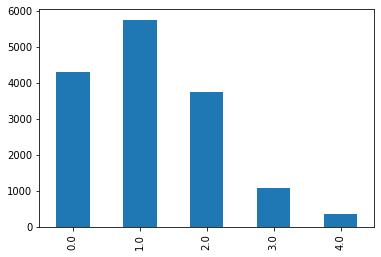

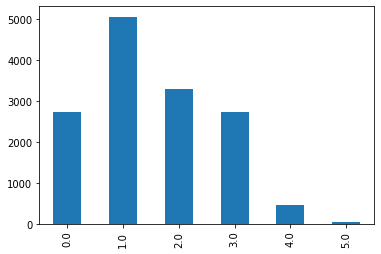

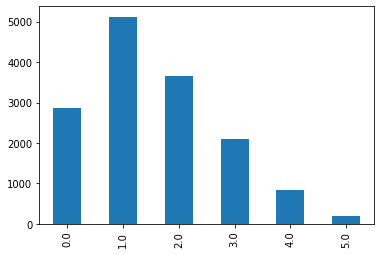

In [26]:
plt.figure(0)
sentiment_df.difference.value_counts().sort_index().plot(kind='bar')
sentiment_df.difference_summary.value_counts().sort_index().plot(kind='bar')
plt.figure(1)
text_blob_df.difference.value_counts().sort_index().plot(kind='bar')
text_blob_df.difference_summary.value_counts().sort_index().plot(kind='bar')
plt.figure(2)
vader_df.difference.value_counts().sort_index().plot(kind='bar')
vader_df.difference_summary.value_counts().sort_index().plot(kind='bar')

In [27]:
def get_processed(df, sentiment_df, text_blob_df, vader_df, words_df):
#Create processed_df with the results of each sentiment execution
  processed_df = df[['overall']].rename(columns={'overall':'result'})

  processed_df['sentiment_intensity'] = sentiment_df['sentiment_raw']
  processed_df['text_blob_sentiment'] = text_blob_df['sentiment_raw']
  processed_df['vader_sentiment'] = vader_df['sentiment_raw']

  processed_df['sentiment_intensity_summary'] = sentiment_df['sentiment_summary_raw']
  processed_df['text_blob_sentiment_summary'] = text_blob_df['sentiment_summary_raw']
  processed_df['vader_sentiment_summary'] = vader_df['sentiment_summary_raw']

  processed_df['word_count'] = words_df['amount']
  processed_df['contrast_words'] = words_df['contrast']
  # processed_df['tense'] = words_df['tense']
  return processed_df
processed_df = get_processed(df, sentiment_df, text_blob_df, vader_df, words_df)
processed_df.head()

,result,sentiment_intensity,text_blob_sentiment,vader_sentiment,sentiment_intensity_summary,text_blob_sentiment_summary,vader_sentiment_summary,word_count,contrast_words
0,1.0,0.0000,0.000000,0.0000,0.0000,0.0,0.0000,6,0.0
4,1.0,-0.4767,-0.500000,-0.4767,0.0000,0.0,0.0000,2,0.0
5,1.0,-0.6232,-0.101389,-0.6232,-0.5423,0.0,-0.5423,17,0.0
7,1.0,-0.6036,-0.035312,-0.6036,0.0772,-0.1,0.0772,49,0.0
8,1.0,0.6400,0.350000,0.6597,0.6369,1.0,0.6369,22,0.0


In [28]:
#Calculate correlation between features and target
processed_df.corr()

,result,sentiment_intensity,text_blob_sentiment,vader_sentiment,sentiment_intensity_summary,text_blob_sentiment_summary,vader_sentiment_summary,word_count,contrast_words
result,1.000000,0.467987,0.411991,0.477673,0.384255,0.291282,0.392223,-0.098077,0.068509
sentiment_intensity,0.467987,1.000000,0.484227,0.950981,0.381727,0.269771,0.382153,0.099368,0.085948
text_blob_sentiment,0.411991,0.484227,1.000000,0.489570,0.217556,0.250066,0.221954,-0.113889,-0.048843
vader_sentiment,0.477673,0.950981,0.489570,1.000000,0.383844,0.276791,0.392792,0.113010,0.088688
sentiment_intensity_summary,0.384255,0.381727,0.217556,0.383844,1.000000,0.647953,0.976463,0.038448,0.042091
text_blob_sentiment_summary,0.291282,0.269771,0.250066,0.276791,0.647953,1.000000,0.652144,0.070050,0.025277
vader_sentiment_summary,0.392223,0.382153,0.221954,0.392792,0.976463,0.652144,1.000000,0.036141,0.045400
word_count,-0.098077,0.099368,-0.113889,0.113010,0.038448,0.070050,0.036141,1.000000,0.007025
contrast_words,0.068509,0.085948,-0.048843,0.088688,0.042091,0.025277,0.045400,0.007025,1.000000


In [29]:
def split_scale_data(processed_df):
  
  #Separate features and target
  X = processed_df.iloc[:,1:].values
  y = processed_df.iloc[:,0].values

  #Split dataset into training dataset and test dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

  #Import Standard Scaler
  from sklearn.preprocessing import StandardScaler

  #Create Standard Scaler
  sc = StandardScaler()

  #Scale features of training dataset and test dataset
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  return X_train, X_test, y_train, y_test

In [30]:
def eval_pred(y_test, y_pred):
  #Compare predicted value and actual target value
  sentiment_df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
  #print(sentiment_df_preds)

  #Calculate Mean Absolute Error
  mae = mean_absolute_error(y_test, y_pred)

  #Calculate Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  #Calculate Root Mean Squared Error
  rmse = np.sqrt(mse)

  acc = accuracy_score(y_test, y_pred)

  std = np.std(y_test-y_pred)

  return [mae, mse, rmse, acc,std]

In [31]:
classifier_predictions = pd.DataFrame()

In [32]:
def fit_and_predict(model, df, save_pred=False):
  #Get training data and test data
  X_train, X_test, y_train, y_test = split_scale_data(df)

  classifier_predictions[0] = y_test

  #Train the model using the training sets
  model.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = model.predict(X_test).round(0)

  if save_pred: classifier_predictions[classifier_predictions.columns.size] = y_pred

  #Evaluate predicted data and return results
  return eval_pred(y_test, y_pred)

In [33]:
def run_and_add(model, origin_df, results_df, name, save_pred=False):
  results_df.loc[len(results_df)] = [name] + fit_and_predict(model, origin_df, save_pred)

def run_models(df, save_pred=False):
  #Initialize DataFrame to store results of predictions
  eval_df = pd.DataFrame(columns=['algorithm', 'mean_absolute_err', 'mean_squared_err', 'root_mean_squared_err', 'accuracy','stdev'])

  #Create various models, train them, and evaluate accuracy
  run_and_add(LinearRegression(), df, eval_df, "Lineal Regression", save_pred)
  run_and_add(KNeighborsClassifier(n_neighbors=5), df, eval_df, "KNN", save_pred)
  run_and_add(RandomForestRegressor(n_estimators=20, random_state=0), df, eval_df, "Random Forests", save_pred)
  run_and_add(AdaBoostClassifier(n_estimators=50, learning_rate=1), df, eval_df, "AdaBoost", save_pred)
  run_and_add(XGBClassifier(), df, eval_df, "XGBoost", save_pred)

  return eval_df

In [34]:
def compare_variables(df):
  columns = df.columns.size - 1

  #Initialize DataFrame to store results of individual variables
  individual_eval_df = pd.DataFrame({'algorithm':["Lineal Regression","KNN","Random Forests","AdaBoost","XGBoost"]})
  for i in range(df.columns.size - 1):
    individual_eval_df[df.columns.tolist()[i+1]] = run_models(df.iloc[:, [0,i+1]])['accuracy']

  individual_eval_df['all'] = run_models(df)['accuracy']

  return individual_eval_df

In [35]:
X_train, X_test, y_train, y_test = train_test_split((text_blob_df['sentiment_raw']*4/2 + 3).round(), processed_df['result'], test_size = 0.2, random_state=2)
ConfusionMatrixDisplay.from_predictions(y_test, X_test, normalize='true')

NameError: ignored

In [36]:
np.std(y_test- X_test)

1.3273496757996441

In [37]:
run_models(processed_df[['result','text_blob_sentiment']], save_pred=True)

,algorithm,mean_absolute_err,mean_squared_err,root_mean_squared_err,accuracy,stdev
0,Lineal Regression,1.075719,1.744813,1.320914,0.241354,1.318965
1,KNN,1.300692,2.876957,1.696159,0.261012,1.695338
2,Random Forests,1.110666,1.915908,1.384163,0.243174,1.384161
3,AdaBoost,1.255916,2.927557,1.711011,0.307244,1.653340
4,XGBoost,1.289407,3.107390,1.762779,0.313797,1.678894


In [38]:
ConfusionMatrixDisplay.from_predictions(classifier_predictions[0], classifier_predictions[4], normalize='true')

NameError: ignored

In [ ]:
run_models(processed_df, save_pred=True)

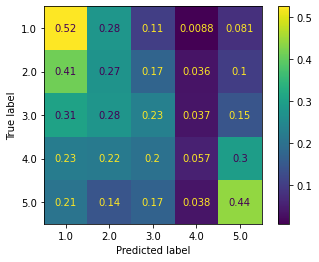

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(classifier_predictions[0], classifier_predictions[4], normalize='true')

In [40]:
compare_variables(processed_df)

,algorithm,sentiment_intensity,text_blob_sentiment,vader_sentiment,sentiment_intensity_summary,text_blob_sentiment_summary,vader_sentiment_summary,word_count,contrast_words,all
0,Lineal Regression,0.255187,0.241354,0.259920,0.254095,0.223517,0.257372,0.183837,0.189297,0.322170
1,KNN,0.311249,0.261012,0.312705,0.272297,0.234438,0.272297,0.216964,0.199126,0.356389
2,Random Forests,0.271933,0.243174,0.283582,0.269385,0.233345,0.268657,0.184565,0.188569,0.342191
3,AdaBoost,0.335639,0.307244,0.338187,0.302512,0.286130,0.285038,0.250819,0.239534,0.392792
4,XGBoost,0.331270,0.313797,0.341463,0.306152,0.288315,0.285766,0.246815,0.223881,0.407353


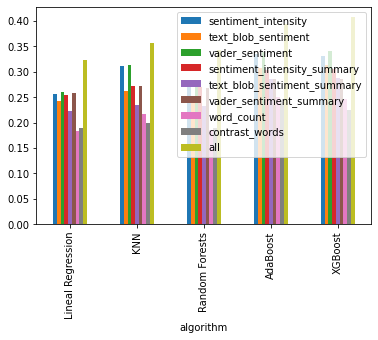

In [42]:
compare_variables(processed_df).set_index('algorithm').plot(kind='bar')

In [43]:
X_train, X_test, y_train, y_test = split_scale_data(processed_df)

model = KNeighborsClassifier(n_neighbors=4)
#Train the model using the training sets
kn_input_df = pd.concat([pd.DataFrame(classifier_predictions).iloc[: , 1:], pd.DataFrame(X_test)], axis=1)

kn_input_df.head()


,1,2,3,4,5,0,1,2,3,4,5,6,7
0,3.0,4.0,3.0,4.0,4.0,0.217831,0.768190,-0.658305,-0.284282,0.798957,-0.279847,-0.262693,1.067072
1,3.0,2.0,3.0,3.0,3.0,1.397557,0.377487,1.379135,-0.595194,-1.324057,-0.589391,1.640760,-0.107880
2,3.0,5.0,3.0,5.0,5.0,-1.357445,0.683410,-1.387182,-0.284282,-0.428810,-0.279847,-0.478178,-0.440414
3,4.0,3.0,4.0,5.0,5.0,1.085158,1.192086,1.074741,-0.284282,-0.428810,-0.279847,-0.585921,-0.440414
4,3.0,3.0,3.0,1.0,1.0,-2.156248,-0.673058,-1.960079,-0.284282,-0.428810,-0.279847,-0.442264,-0.440414


In [44]:

model.fit(kn_input_df, y_test)

vader_df = vader(one_third)
text_blob_df = text_blob(one_third)
sentiment_df = intensity(one_third)

words_df = makeWords(one_third)
words_df = getMoreWordyStuff(words_df)
processed_df5 = get_processed(one_third, sentiment_df, text_blob_df, vader_df, words_df)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
classifier_predictions = pd.DataFrame()

run_models(processed_df5, save_pred=True)

X_train, X_test, y_train, y_test = split_scale_data(processed_df5)
kn_testinput_df = pd.concat([pd.DataFrame(classifier_predictions), pd.DataFrame(X_test)], axis=1)
kn_testinput_df = kn_testinput_df.iloc[: , 1:]
kn_testinput_df.head()

,1,2,3,4,5,0,1,2,3,4,5,6,7
0,3.0,3.0,2.0,4.0,2.0,1.245315,0.043745,1.186429,-0.295878,-0.436904,-0.288486,1.860941,-0.447387
1,3.0,2.0,3.0,3.0,3.0,-0.379632,-0.666960,-0.395016,0.386466,1.094204,0.392463,-0.433306,2.066954
2,3.0,4.0,4.0,3.0,4.0,-0.019110,-0.109023,-0.032141,1.032023,1.706647,1.036703,-0.247286,1.061217
3,3.0,2.0,3.0,3.0,2.0,-0.452083,-0.666960,-0.467940,-0.295878,-0.436904,-0.288486,-0.619326,-0.447387
4,2.0,2.0,2.0,1.0,2.0,-1.138249,-0.823880,-1.158585,-0.295878,-0.436904,-0.288486,0.775824,0.024052


In [46]:
y_pred1 = model.predict(kn_testinput_df).round(0)

eval_pred(y_test, y_pred1)

[1.0737623762376238,
 2.1995049504950495,
 1.4830728068759973,
 0.3316831683168317,
 1.44308238365082]

In [47]:
secondXGBOOST_input_df = pd.concat([pd.DataFrame(kn_testinput_df), pd.DataFrame(y_pred1)], axis=1)
secondXGBOOST_input_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']
secondXGBOOST_input_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14
0,3.0,3.0,2.0,4.0,2.0,1.245315,0.043745,1.186429,-0.295878,-0.436904,-0.288486,1.860941,-0.447387,1.0
1,3.0,2.0,3.0,3.0,3.0,-0.379632,-0.666960,-0.395016,0.386466,1.094204,0.392463,-0.433306,2.066954,3.0
2,3.0,4.0,4.0,3.0,4.0,-0.019110,-0.109023,-0.032141,1.032023,1.706647,1.036703,-0.247286,1.061217,3.0
3,3.0,2.0,3.0,3.0,2.0,-0.452083,-0.666960,-0.467940,-0.295878,-0.436904,-0.288486,-0.619326,-0.447387,1.0
4,2.0,2.0,2.0,1.0,2.0,-1.138249,-0.823880,-1.158585,-0.295878,-0.436904,-0.288486,0.775824,0.024052,3.0


In [48]:
Zmodel = XGBClassifier()

y_testZ = y_test 

Zmodel.fit(secondXGBOOST_input_df, y_testZ)

vader_df = vader(two_third)
text_blob_df = text_blob(two_third)
sentiment_df = intensity(two_third)

words_df = makeWords(two_third)
words_df = getMoreWordyStuff(words_df)
processed_df = get_processed(two_third, sentiment_df, text_blob_df, vader_df, words_df)
classifier_predictions = pd.DataFrame()

run_models(processed_df, save_pred=True)
X_train, X_test, y_train, y_test = split_scale_data(processed_df)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1.3321317571762403
0.3976348854397635


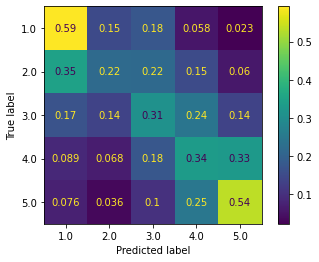

In [68]:
kn_testinput_df = pd.concat([pd.DataFrame(classifier_predictions), pd.DataFrame(X_test)], axis=1)
kn_testinput_df = kn_testinput_df.iloc[: , 1:]
y_pred = model.predict(kn_testinput_df).round(0)
secondXGBOOST_input_df = pd.concat([pd.DataFrame(kn_testinput_df), pd.DataFrame(y_pred)], axis=1)


secondXGBOOST_input_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']
finalModel_y_pred = Zmodel.predict(secondXGBOOST_input_df).round(0)

ConfusionMatrixDisplay.from_predictions(y_test, finalModel_y_pred, normalize='true')
  #Calculate Mean Squared Error
mse = mean_squared_error(y_test, finalModel_y_pred)

  #Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print(rmse)
acc = accuracy_score(y_test, finalModel_y_pred)
print(acc)

In [50]:
mean_squared_error(y_test, finalModel_y_pred)

1.7745750184774576

In [51]:
accuracy_score(y_test,finalModel_y_pred)

0.3976348854397635

In [52]:
np.std(y_test- finalModel_y_pred)

1.3321315521415895

In [53]:

# model.fit(secondKNN_input_df, y_test)

# X_train, X_test, y_train, y_test = split_scale_data(one_third)

# #Predict the response for test dataset
# y_pred = model.predict(secondKNN_input_df).round(0)

# eval_pred(y_test, y_pred)

In [54]:
# secondXGBOOST_input_df = pd.concat([pd.DataFrame(secondKNN_input_df), pd.DataFrame(y_pred)], axis=1)


# model = XGBClassifier()

# model.fit(secondXGBOOST_input_df, y_train)
# y_pred_final = model.predict(X_test).round(0)

# eval_pred(y_test, y_pred_final)

In [55]:
# ConfusionMatrixDisplay.from_predictions(y_train, y_pred_final, normalize='true')

In [56]:
#Keras

# import tensorflow as tf
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense,Input
# from sklearn.utils import shuffle
# import tensorflow_hub as hub
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# import numpy as np
# import os
# import pandas as pd
# from sklearn.metrics import accuracy_score

# X_train, X_test, y_train, y_test = split_scale_data(processed_df)


# keras_input_df = pd.concat([pd.DataFrame(classifier_predictions), pd.DataFrame(X_test)], axis=1)
# # keras_input_df.head()
# # pd.DataFrame(X_test).head() 
# keras_input_df.shape 



In [57]:
# model = Sequential()
# model.add(Input(shape=(8,),dtype='float32'))
# model.add(Dense(8, activation = 'relu'))
# model.add(Dense(4, activation = 'relu'))
# model.add(Dense(1, activation = 'sigmoid'))

# model.compile(loss='binary_crossentropy', 
#               optimizer='adam',
#               metrics=['acc'])

In [58]:
# num_epochs = 40
# batch_size = 100   ## 2^x

# history = model.fit(X_train, 
#                     y_train, 
#                     epochs=num_epochs, 
#                     validation_split=0.01, 
#                     shuffle=True,
#                     batch_size=batch_size)

In [59]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy') 
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')


In [60]:
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#stopwords = set(stopwords.words('english'))
#import re

#def tokenize_content(content):
#  return list(filter(lambda x: (re.match(r"^^[a-zA-Z]+$", x) and (x not in stopwords)), map(str.lower,nltk.word_tokenize(content))))
#big_df = value_df.reviewText.apply(tokenize_content)

In [61]:
#word_list = big_df.tolist()
#word_amounts_df = pd.DataFrame([item for entry in word_list for item in entry], columns=['words'])
#word_amounts_df = word_amounts_df.value_counts()
#word_amounts_df[word_amounts_df > 100]

In [62]:
#Some words will be present in higher amounts in a certain review category

#for value in df['overall'].unique():
  #Separate each category
#  value_df = df[df['overall'] == value]
  #Extract all words
#  words_atomic = value_df.reviewText.apply(tokenize_content)
  #Count repeated words
#  words_amounts = pd.DataFrame([item for entry in words_atomic for item in entry], columns=['words']).value_counts()
#  word_amounts = word_amounts[word_amounts > 100]